<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 - Sentiment Analysis Model (Problem 1)</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

Objective: Build a sentiment analysis model to predict the emoticon for each text input. 


In [1]:
DATA_DIR = "../data"

In [2]:
# autoformat code on cell run.
%load_ext lab_black
# Import the Required Packages
import os
import mlflow
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as pl

from git import Repo
from textblob import TextBlob
from emot import emoji, emoticons
from nlpre import replace_from_dictionary
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, stem_text

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.1.0) requires spaCy v2.1 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Configure access to MLFlow by setting the following environment variables:
- `MLFLOW_TRACKING_URI` - URL to the MLFlow Tracking server.
- `MLFLOW_S3_ENDPOINT_URL` - URL to the MLFlow S3 Backend Store
- `MLFLOW_EXPERIMENT` - Optional. The name of the MLFlow experiment to log to.
- `AWS_ACCESS_KEY_ID` - MLFlow S3 backend store Access Key ID.
- `AWS_SECRET_ACCESS_KEY` - MLFlow S3 backend store secret access key.

`TF_FORCE_GPU_ALLOW_GROWTH` -  Force Tensorflow to allocate GPU memory dynamically
instead of of all at once as a workaround for this
[cuDNN failed to initialize issue](https://github.com/tensorflow/tensorflow/issues/24828).

In [3]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


Start MLFlow run with the name of the commit as fthe run name.

In [4]:
mlflow.set_experiment(os.environ.get("MLFLOW_EXPERIMENT", "staging"))

In [5]:
repo = Repo(search_parent_directories=True)
mlflow.start_run(run_name=repo.head.commit.message)

<ActiveRun: >

# Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [6]:
# Load the emoji_dictionary
df = pd.read_csv(f"{DATA_DIR}/mapping.csv", delimiter=",")
emoji_dictionary = df.loc[:, "emoticons"].to_dict()
print(emoji_dictionary)
print("A total of: ", len(emoji_dictionary), "Emoji Icons")

{0: '😍', 1: '😂', 2: '📷', 3: '🔥', 4: '❤'}
A total of:  5 Emoji Icons


Since the emojis can't be rendered in some situations such as graph plotting, create a mapping for the labels to emoji nameategorical types for the grouping variables to control the order of plot elements.

In [7]:
emoji_names = {
    0: "heart-eyes",
    1: "crying-laughing",
    2: "camera",
    3: "fire",
    4: "heart",
}

In [8]:
# load the dataset
df = pd.read_csv(f"{DATA_DIR}/dataset.csv", delimiter=",")
texts = df.loc[:, "TEXT"].values
labels = df.loc[:, "Label"].values

In [9]:
# Check the maximum length of texts
max_len = -1
for example in texts:
    if len(example.split()) > max_len:
        max_len = len(example.split())

print("the maximum length of the text inputs is ", max_len)

the maximum length of the text inputs is  34


### 1.2 EDA

View the first 5 rows of data:

In [10]:
df.head()

,TEXT,Label
0,Been friends since 7th grade. Look at us now w...,0
1,This is what it looks like when someone loves ...,1
2,RT @user this white family was invited to a Bl...,1
3,"Westenders @user #LAZzNation @ Weston, Toronto\n",2
4,Maxwell heads home @ Summa Akron City Hospital\n,0


Splice in actual emojis and names to make the data easier to grasp than raw number labels:

In [11]:
df["Emoji"] = df["Label"].map(emoji_dictionary)
df["EmojiName"] = df["Label"].map(emoji_names)
df.head()

,TEXT,Label,Emoji,EmojiName
0,Been friends since 7th grade. Look at us now w...,0,😍,heart-eyes
1,This is what it looks like when someone loves ...,1,😂,crying-laughing
2,RT @user this white family was invited to a Bl...,1,😂,crying-laughing
3,"Westenders @user #LAZzNation @ Weston, Toronto\n",2,📷,camera
4,Maxwell heads home @ Summa Akron City Hospital\n,0,😍,heart-eyes


Visualise the distribution of the data examples for each Emoji to check for class imbalance:


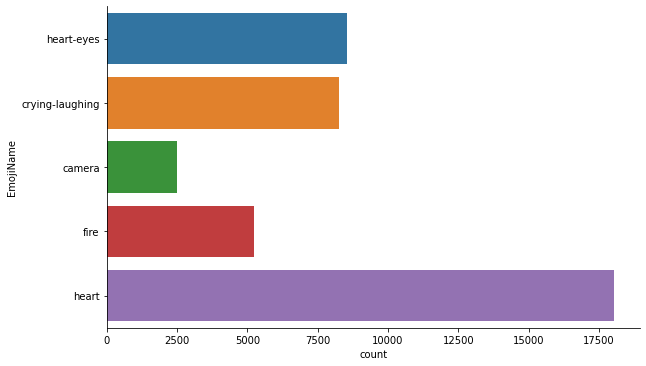

In [12]:
sns.catplot(kind="count", data=df, y="EmojiName", aspect=16 / 9)

In [13]:
df["Emoji"].value_counts()

❤    18043
😍     8537
😂     8247
🔥     5223
📷     2496
Name: Emoji, dtype: int64

Observations:
- The disparty between the number of examples between the different Emojis show a significant class imbalance.
- Metrics such as accuracy will not produce accurate results until the class imbalance issue is resolved. [[1]](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/)

Glancing through the data examples, one can make the following observations about the data:
- Although there are no Emojis used in the data, emoticons such as `:)` or `:(` are present in the text data.
- Common contractions ie `w/` to represent `with` are present in the text data.
- Stylised words such as `O B E S S E D` will need to be converted its normal `obsessed` equavilent
- Location words seem highly indicative that the class should be a 📷
- The dataset mentions many locations in the US, as such state contractions such as NY for New York, LA for Los Angles can be safely expanded.

### 1.2 Data Processing


Split the data to train/test subsets reserve 1000 examples for the test set:

In [14]:
n_test = 5000
mlflow.log_param("test_size", n_test)
# Split the X & y into train and test set
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["TEXT"], df["Label"], test_size=n_test
)

Cleaning text data [[2]](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing) [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0957417418303683)
- `lower_case` - Convert all text tokens to lower case so that `Happy` and `happy` will appear the same to the model.
- `replace_emot` - Replace emoticons such `:)` with their textual equvilent `happy`.
- `remove_punc` - Remove punctuations such that `yes!` and `yes` would appear the same to model. Also removes trailing newlines.
- `replace_abbv` - Replace common abbreviations and contractions by by look up their full forms. Uses [slang.txt](https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt)
- `stopwords` - Removal of stopwords: meaningless words such as `the`, `a`, that are likely irrelevant to prediction.
- `stemming` - Remove inflections from words (ie jump**ing**, jump**ed**, jump**s**,) by steming them. Mutually exclusive with `lemmatization`. Implies `lower_case`.
- `lemmatization` - Remove inflections from words by looking up the word's lemma. Mutually exclusive with `stemming`.
- TODO: remove numbers

In [15]:
def replace(text, mapping):
    """Replace words in the text that match the key in the mapping dict with its value"""
    for word in TextBlob(text).words:
        word = str(word)
        if word in mapping:
            text = text.replace(word, mapping[word])
    return text

Download corpora for replacing abbrevations

In [16]:
!wget https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt -O slang.txt

--2021-01-31 10:13:17--  https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5181 (5.1K) [text/plain]
Saving to: ‘slang.txt’

slang.txt           100%[===================>]   5.06K  --.-KB/s    in 0s      

2021-01-31 10:13:17 (73.9 MB/s) - ‘slang.txt’ saved [5181/5181]



In [17]:
!wget https://gist.githubusercontent.com/rugbyprof/76575b470b6772ce8fa0c49e23931d97/raw/eb731ce40f9c7c032f4db42e96889a3adbe54f8e/states.py -O states.py

--2021-01-31 10:13:17--  https://gist.githubusercontent.com/rugbyprof/76575b470b6772ce8fa0c49e23931d97/raw/eb731ce40f9c7c032f4db42e96889a3adbe54f8e/states.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.8.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1091 (1.1K) [text/plain]
Saving to: ‘states.py’

states.py           100%[===================>]   1.07K  --.-KB/s    in 0s      

2021-01-31 10:13:17 (126 MB/s) - ‘states.py’ saved [1091/1091]



In [18]:
clean_params = {
    "lower_case": True,
    "replace_emot": True,
    "remove_punc": True,
    "replace_abbv": True,
    "stopwords": True,
    "stemming": False,
    "lemmatization": True,
}
mlflow.log_params(clean_params)

In [19]:
from states import states as states_map


def clean_texts(texts, clean_params=clean_params):
    """Cleans the given texts applying clean techniques specified in clean_params
    Returns:
        The given texts with clean techniques applied
    """
    # check mutually exclusive parameters
    assert not (clean_params["stemming"] and clean_params["lemmatization"])

    # apply cleaning techniques on copy of dataframe
    if clean_params["lower_case"]:
        texts = np.asarray([t.lower() for t in texts])

    if clean_params["replace_emot"]:

        def replace_emot(text):
            # replace emoticons with meaning if present
            results = emoticons(text)
            if results["flag"]:
                n_emoticons = len(results["value"])
                for location, meaning in zip(results["location"], results["mean"]):
                    start, end = location
                    # fix "andry" spelling mistake
                    # https://github.com/NeelShah18/emot/pull/19/files
                    meaning = meaning.replace("andry", "angry")
                    text = f"{text[:start]} {meaning} {text[end+1:]}"
            return text

        texts = np.asarray([replace_emot(t) for t in texts])

    if clean_params["remove_punc"]:
        # … not recognized as puncuation, so remove it manually
        texts = np.asarray(
            [strip_punctuation(t.rstrip().replace("…", "")) for t in texts]
        )

    if clean_params["replace_abbv"]:
        # use utf-sig to fix escape characters
        with open("slang.txt", "r", encoding="utf-8-sig") as f:
            lines = f.readlines()
        abbv_pairs = [tuple(line.split(maxsplit=1)) for line in lines]
        # remove trailing newlines
        abbv_map = {
            # \xa0 - for some reason latin spaces are present, replace with normal spaces.
            abbv: full.rstrip().replace("\xa0", "")
            for abbv, full in abbv_pairs
        }
        # additional abbrevation entries
        abbv_map.update(
            {
                "em": "them",
                "v": "very",
            }
        )
        # expand  US state abbrevations
        abbv_map.update(
            {code.lower(): name.lower() for code, name in states_map.items()}
        )
        texts = np.asarray([replace(t, abbv_map) for t in texts])

    if clean_params["stopwords"]:
        texts = np.asarray([remove_stopwords(t) for t in texts])
    if clean_params["stemming"]:
        texts = np.asarray([stem_text(t) for t in texts])
    if clean_params["lemmatization"]:

        def lemmatize(text):
            lemma_map = {str(w): w.lemmatize() for w in TextBlob(text).words}
            return replace(text, lemma_map)

        texts = np.asarray([lemmatize(t) for t in texts])

    return texts

In [20]:
%%time
clean_train_texts = clean_texts(train_texts, clean_params)
clean_test_texts = clean_texts(test_texts, clean_params)

CPU times: user 20.6 s, sys: 129 ms, total: 20.7 s
Wall time: 20.7 s


Converting text into vectors:
- `one_hot` - one hot encoding of the word vector data, acts as baseline.
- `fasttext_pretrained` - pretrained fasttext vectors
- `fasttext` - fastext vectors trained on our dataset.
- `doc2vec`- doc2vec vectors trained on our dataset.
- `doc2vec_preatrained`- doc2vec pretrained vectors.
- `lexvec` - LexVec vectors trained on our dataset.
- `lexvec_pretrained` - LexVec retrained vectors.

> Out of interests of time, `word2vec` is not included as`word2vec` vectors are significantly worst as compared to `fasttext` [[3]](https://github.com/RaRe-Technologies/gensim/blob/ba1ce894a5192fc493a865c535202695bb3c0424/docs/notebooks/Word2Vec_FastText_Comparison.ipynb)

In [21]:
# Convert the texts and labels into numeric tensors

### 1.3 Data Sampling

To combat the class imbalance issue we have a couple of options:
- `oversample` : Use Random Oversampling to duplicate the data examples for Emojis smaller no. of examples to match the majority class.
- `undersample`: Use Random Undersampling to undersample the data examples for the Majority Emoji cass to match the minority class.
- `SMOTE`: Interpolate new systhesised training examples
- TODO: continue

## Step 2 – Develop a Sentiment Analysis Model

### Model #1

In [22]:
# Build the Model

In [23]:
# Train the Model

In [24]:
# Plot the Training and Validation Accuracy & Loss Scores

In [25]:
# Save the Model
# model.save('text_model_1.h5')

### Model #2

In [26]:
# Build the Model

In [27]:
# Train the Model

In [28]:
# Plot the Training and Validation Accuracy & Loss Scores

In [29]:
# Save the Model
# model.save('text_model_2.h5')

## Step 3 – Evaluate the Model using Testing Data 

In [30]:
# Model #1 (replicate where necessary for other models)
# model.load_weights('text_model_1.h5')

In [31]:
# Save the Best Model
# model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction

In [32]:
# model.load_weights('text_model_best.h5')

In [33]:
# takes the user input
# text_input = np.array([input()])

In [34]:
# convert the user input into numeric tensor

In [35]:
# show the model output using predict function

# References
- [1] Failure of Classification Accuracy for Imbalanced Class Distributions. (2021, January 21). Retrieved from https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions  
- [2] sudalairajkumar. (2019). Getting started with Text Preprocessing. Kaggle. Retrieved from https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
- [3] RaRe-Technologies. (2021, January 28). gensim. Retrieved from https://github.com/RaRe-Technologies/gensim/blob/ba1ce894a5192fc493a865c535202695bb3c0424/docs/notebooks/Word2Vec_FastText_Comparison.ipynb
- [4] Symeonidis, S., Effrosynidis, D., & Arampatzis, A. (2018). A comparative evaluation of pre-processing techniques and their interactions for twitter sentiment analysis. Expert Syst. Appl., 110, 298–310. doi: 10.1016/j.eswa.2018.06.022